- Setup the environment

In [1]:
import sys
import os
cur_dir = os.getcwd()
# Add the current directory to system path (including parent folder)
sys.path.append(cur_dir)
sys.path.append(os.path.split(cur_dir)[0])

- Load input data

Create sample data

In [2]:
import pandas as pd
import numpy as np
# Prepare sample data
timestamp = pd.date_range(start='2020-01-01', periods=300, freq='D')
time_series = pd.DataFrame({'values': np.random.randn(300)}, index=timestamp)
labels = pd.DataFrame({'label': np.random.randn(300)}, index=timestamp)
ext_features = pd.DataFrame({
    'feature1': np.random.randn(300),
    'feature2': np.random.randn(300)
}, index=timestamp)

combined_data = time_series.join(labels).join(ext_features)

Train / Validation / Test split

In [3]:
# Train / Validation / Test Split
train_data = combined_data[:100]
val_data = combined_data[100:200]
test_data = combined_data[200:]

# Read targets
train_target = train_data.label.values
val_target = val_data.label.values
test_target = test_data.label.values

# Read features
train_features = train_data[['feature1', 'feature2']].values
val_features = val_data[['feature1', 'feature2']].values
test_features = test_data[['feature1', 'feature2']].values

In [4]:
from pl_model_utils import TimeSeriesDataModule
# Instantiate data module and model
data_module = TimeSeriesDataModule(
    train_target, train_features,
    val_target, val_features,
    test_target, test_features,
    batch_size=16
)

# Setup the data for model
data_module.setup()

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Classification with Basic Autoencoder

- Compile simple Autoencoder for Classification

In [5]:
from pl_autoencoder_classifiers import AutoencoderClassifier
ae_model = AutoencoderClassifier(context_length=1, num_classes=3, num_features=2, task='regression')

In [6]:
from pytorch_lightning.callbacks import ModelCheckpoint
# Define a checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
)

- Train the Autoencoder

In [7]:
from pytorch_lightning import Trainer
# Train the model
trainer = Trainer(max_epochs=20, callbacks=[checkpoint_callback])
trainer.fit(ae_model, data_module.train_dataloader())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 8.8 K 
1 | decoder    | Sequential | 8.4 K 
2 | classifier | Sequential | 2.2 K 
3 | softmax    | Softmax    | 0     
------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\miniconda3\envs\GluonTS\lib\si

Epoch 19: 100%|██████████| 7/7 [00:00<00:00, 121.42it/s, v_num=132]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 7/7 [00:00<00:00, 103.05it/s, v_num=132]


- Cross-Validation (Using Combinatorial Purged K-Fold CV)

In [8]:
from pl_model_utils import cross_validate_model
from CPCV.cpcv import CombPurgedKFoldCVLocal


pred_times = pd.Series(val_data.index, index=val_data.index)
eval_times = pd.Series(val_data.index, index=val_data.index)

# Construct CPCV in-line with DePrado method
cpcv = CombPurgedKFoldCVLocal(
    n_splits=10,
    n_test_splits=1,
    embargo_td=pd.Timedelta(days=2)
)

cv_split = cpcv.split(
    pd.DataFrame(data_module.val_features, index=val_data.index), 
    pd.Series(data_module.val_target, index=val_data.index), 
    pred_times, 
    eval_times)

# Perform cross-validation
cv_results = cross_validate_model(
    X=data_module.val_features,
    y=data_module.val_target,
    model=ae_model,
    cv_split=cv_split)

0it [00:00, ?it/s]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 8.8 K 
1 | decoder    | Sequential | 8.4 K 
2 | classifier | Sequential | 2.2 K 
3 | softmax    | Softmax    | 0     
------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\loops\fit_loop.py:280: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 112.98it/s, v_num=133]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 91.39it/s, v_num=133] 

1it [00:03,  3.37s/it]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 8.8 K 
1 | decoder    | Sequential | 8.4 K 
2 | classifier | Sequential | 2.2 K 
3 | softmax    | Softmax    | 0     
------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\miniconda3\envs\GluonTS\lib\si

Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 104.91it/s, v_num=134]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 88.39it/s, v_num=134] 


2it [00:06,  3.33s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 8.8 K 
1 | decoder    | Sequential | 8.4 K 
2 | classifier | Sequential | 2.2 K 
3 | softmax    | Softmax    | 0     
------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\minicond

Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 94.28it/s, v_num=135] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 80.06it/s, v_num=135]

3it [00:10,  3.48s/it]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 8.8 K 
1 | decoder    | Sequential | 8.4 K 
2 | classifier | Sequential | 2.2 K 
3 | softmax    | Softmax    | 0     
------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\miniconda3\envs\GluonTS\lib\si

Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 91.43it/s, v_num=136] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 76.04it/s, v_num=136]

4it [00:13,  3.54s/it]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 8.8 K 
1 | decoder    | Sequential | 8.4 K 
2 | classifier | Sequential | 2.2 K 
3 | softmax    | Softmax    | 0     
------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\miniconda3\envs\GluonTS\lib\si

Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 113.00it/s, v_num=137]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 94.06it/s, v_num=137] 

5it [00:17,  3.52s/it]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 8.8 K 
1 | decoder    | Sequential | 8.4 K 
2 | classifier | Sequential | 2.2 K 
3 | softmax    | Softmax    | 0     
------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\miniconda3\envs\GluonTS\lib\si

Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 109.60it/s, v_num=138]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 90.87it/s, v_num=138] 

6it [00:20,  3.45s/it]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 8.8 K 
1 | decoder    | Sequential | 8.4 K 
2 | classifier | Sequential | 2.2 K 
3 | softmax    | Softmax    | 0     
------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\miniconda3\envs\GluonTS\lib\si

Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 110.75it/s, v_num=139]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 90.99it/s, v_num=139] 

7it [00:24,  3.39s/it]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 8.8 K 
1 | decoder    | Sequential | 8.4 K 
2 | classifier | Sequential | 2.2 K 
3 | softmax    | Softmax    | 0     
------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\miniconda3\envs\GluonTS\lib\si

Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 99.69it/s, v_num=140] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 82.65it/s, v_num=140]

8it [00:27,  3.36s/it]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 8.8 K 
1 | decoder    | Sequential | 8.4 K 
2 | classifier | Sequential | 2.2 K 
3 | softmax    | Softmax    | 0     
------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\miniconda3\envs\GluonTS\lib\si

Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 96.54it/s, v_num=141] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 79.72it/s, v_num=141]

9it [00:30,  3.44s/it]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 8.8 K 
1 | decoder    | Sequential | 8.4 K 
2 | classifier | Sequential | 2.2 K 
3 | softmax    | Softmax    | 0     
------------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\miniconda3\envs\GluonTS\lib\si

Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 100.55it/s, v_num=142]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 86.20it/s, v_num=142] 

10it [00:34,  3.38s/it]

10it [00:34,  3.42s/it]

Cross-Validation Report:
{'Fold_0': 0.78342783, 'Fold_1': 1.0746402, 'Fold_2': 0.30051118, 'Fold_3': 0.39082208, 'Fold_4': 0.21280167, 'Fold_5': 0.37165302, 'Fold_6': 0.9396434, 'Fold_7': 0.89639485, 'Fold_8': 0.68916124, 'Fold_9': 0.49383968}


In [9]:
pd.DataFrame(cv_results.items(), columns=['Folds', 'Loss'])

,Folds,Loss
0,Fold_0,0.783428
1,Fold_1,1.074640
2,Fold_2,0.300511
3,Fold_3,0.390822
4,Fold_4,0.212802
5,Fold_5,0.371653
6,Fold_6,0.939643
7,Fold_7,0.896395
8,Fold_8,0.689161
9,Fold_9,0.493840


In [10]:
from mc_dropout import mc_dropout # final, one-line function to implement mc dropout (As suggested here: https://github.com/Lightning-AI/pytorch-lightning/blob/f35e2210e240b443fd4dafed8fe2e30ee7d579ea/docs/source/common/production_inference.rst#prediction-api)
predictions_mean, predictions_std = mc_dropout(ae_model, data_module.val_dataloader(), mc_iterations=100)

100%|██████████| 7/7 [00:00<00:00, 18.16it/s]


## Classification with Attention-Enchanced Autoencoder

## Hyperparameter Tuning

In [11]:
from pytorch_lightning.callbacks import EarlyStopping
from pl_autoencoder_classifiers import AutoencoderAttentionClassifier
from pl_model_utils import TimeSeriesDataset
import pytorch_lightning as pl
import torch
from sklearn.model_selection import TimeSeriesSplit
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import log_loss, mean_squared_error
import optuna
import numpy as np

def ae_attention_objective(trial):
    context_length = 1
    num_classes = 3
    num_features = 2

    # Suggest hyperparameters
    lr = trial.suggest_categorical('lr', [1e-5, 1e-3, 1e-2])
    num_heads = trial.suggest_categorical('num_heads', [1, 2, 4])
    dropout_prob = trial.suggest_categorical('dropout_prob', [0.1, 0.3, 0.5])
    hidden_units = trial.suggest_categorical('hidden_units', [64, 128, 256])
    embed_dim = trial.suggest_categorical('embed_dim', [32, 64, 128])
    # classifier_units = trial.suggest_categorical('classifier_units', [16, 32, 64])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Initialize the model with suggested hyperparameters
    model = AutoencoderAttentionClassifier(
        context_length=context_length,
        num_classes=num_classes,
        num_features=num_features,
        num_heads=num_heads,
        dropout_prob=dropout_prob,
        hidden_units=hidden_units,
        embed_dim=embed_dim,
        # classifier_units=classifier_units,
        lr=lr,
        task='regression'
    )

    # Assuming you have your dataset in `X` and `y`
    X, y = data_module.val_features, data_module.val_target
    # X = np.array(X_train)  # Ensure X_train is a NumPy array
    # y = np.array(y_train)  # Ensure y_train is a NumPy array

    # Time series split
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = []

    for train_index, val_index in tscv.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Create DataLoader for the training and validation fold
        train_dataset = TimeSeriesDataset(
            torch.tensor(y_train_fold, dtype=torch.float32), 
            torch.tensor(X_train_fold, dtype=torch.float32)
            )
        
        val_dataset = TimeSeriesDataset(
            torch.tensor(y_val_fold, dtype=torch.float32), 
            torch.tensor(X_val_fold, dtype=torch.float32)
            )
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize trainer
        trainer = pl.Trainer(
            max_epochs=10,
            callbacks=[EarlyStopping(monitor='train_loss', patience=3, mode='min')],
            logger=False,
            enable_checkpointing=False
        )

        # Train the model
        trainer.fit(model, train_loader)

        # Validate the model

        model.eval()
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for batch in val_loader:
                targets, features = batch
                if model.task == 'classification': 
                    _, classification = model(targets, features)
                    all_preds.extend(classification.cpu().numpy())
                elif model.task == 'regression': 
                    out = model(targets, features)
                    all_preds.extend(out.cpu().numpy())
                # preds = torch.argmax(classification, dim=1)
                all_targets.extend(targets.cpu().numpy())

        # val_predictions = trainer.predict(model, val_loader)
        # val_predictions = torch.cat([x for x in val_predictions], dim=0).numpy()
        
        val_loss = log_loss(all_targets, all_preds) if model.task == 'classification' else mean_squared_error(all_targets, all_preds)
        cv_scores.append(val_loss)

    return np.mean(cv_scores)

In [12]:
# Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(ae_attention_objective, n_trials=10)

[I 2024-09-03 14:35:06,068] A new study created in memory with name: no-name-d6aa0879-4209-44dd-9642-c821a6486dfa
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.0 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 16.6 K
-------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this ma

Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] 

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 60.38it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.0 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 16.6 K
-------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3:  33%|███▎      | 1/3 [00:00<00:00, 54.09it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4: 100%|██████████| 3/3 [00:00<00:00, 46.29it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.0 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 16.6 K
-------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 2:  50%|█████     | 2/4 [00:00<00:00, 68.53it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 4/4 [00:00<00:00, 51.02it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.0 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 16.6 K
-------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 2:  40%|████      | 2/5 [00:00<00:00, 65.71it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 29.92it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.0 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 16.6 K
-------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1:  17%|█▋        | 1/6 [00:00<00:00, 39.77it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 6/6 [00:00<00:00, 67.20it/s]

[I 2024-09-03 14:35:08,608] Trial 0 finished with value: 0.988956093788147 and parameters: {'lr': 0.001, 'num_heads': 1, 'dropout_prob': 0.3, 'hidden_units': 128, 'embed_dim': 128, 'batch_size': 16}. Best is trial 0 with value: 0.988956093788147.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.5 K
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 16.9 K
-------------------------------------------------
51.0 K    Trainable params
0         Non-trainable params
51.0 K    Total params
0.204     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 78.03it/s] 

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 51.13it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.5 K
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 16.9 K
-------------------------------------------------
51.0 K    Trainable params
0         Non-trainable params
51.0 K    Total params
0.204     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 61.65it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.5 K
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 16.9 K
-------------------------------------------------
51.0 K    Trainable params
0         Non-trainable params
51.0 K    Total params
0.204     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 66.76it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 9: 100%|██████████| 2/2 [00:00<00:00, 56.68it/s] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2/2 [00:00<00:00, 52.01it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.5 K
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 16.9 K
-------------------------------------------------
51.0 K    Trainable params
0         Non-trainable params
51.0 K    Total params
0.204     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s] 

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1:  33%|███▎      | 1/3 [00:00<00:00, 62.83it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4: 100%|██████████| 3/3 [00:00<00:00, 60.09it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.5 K
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 16.9 K
-------------------------------------------------
51.0 K    Trainable params
0         Non-trainable params
51.0 K    Total params
0.204     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3:  33%|███▎      | 1/3 [00:00<00:00, 63.32it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4: 100%|██████████| 3/3 [00:00<00:00, 60.15it/s]

[I 2024-09-03 14:35:10,259] Trial 1 finished with value: 1.014594316482544 and parameters: {'lr': 1e-05, 'num_heads': 4, 'dropout_prob': 0.5, 'hidden_units': 256, 'embed_dim': 64, 'batch_size': 32}. Best is trial 0 with value: 0.988956093788147.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 33.9 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 33.3 K
-------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.533     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s]        

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 33.9 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 33.3 K
-------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.533     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 54.87it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 33.9 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 33.3 K
-------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.533     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 64.33it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 33.9 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 33.3 K
-------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.533     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 2: 100%|██████████| 3/3 [00:00<00:00, 64.37it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 3/3 [00:00<00:00, 48.87it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 33.9 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 33.3 K
-------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.533     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 2: 100%|██████████| 3/3 [00:00<00:00, 64.97it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 3/3 [00:00<00:00, 53.22it/s]


[I 2024-09-03 14:35:11,683] Trial 2 finished with value: 0.988956093788147 and parameters: {'lr': 0.01, 'num_heads': 2, 'dropout_prob': 0.1, 'hidden_units': 256, 'embed_dim': 128, 'batch_size': 32}. Best is trial 0 with value: 0.988956093788147.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 9.2 K 
1 | attention | MultiheadAttention | 4.2 K 
2 | decoder   | Sequential         | 8.7 K 
-------------------------------------------------
22.2 K    Trainable params
0         Non-trainable params
22.2 K    Total params
0.089     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers w

Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s]        

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 41.69it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 9.2 K 
1 | attention | MultiheadAttention | 4.2 K 
2 | decoder   | Sequential         | 8.7 K 
-------------------------------------------------
22.2 K    Trainable params
0         Non-trainable params
22.2 K    Total params
0.089     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3: 100%|██████████| 3/3 [00:00<00:00, 84.04it/s] 

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 3/3 [00:00<00:00, 68.22it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 9.2 K 
1 | attention | MultiheadAttention | 4.2 K 
2 | decoder   | Sequential         | 8.7 K 
-------------------------------------------------
22.2 K    Trainable params
0         Non-trainable params
22.2 K    Total params
0.089     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 2:  75%|███████▌  | 3/4 [00:00<00:00, 72.94it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 4/4 [00:00<00:00, 54.08it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 9.2 K 
1 | attention | MultiheadAttention | 4.2 K 
2 | decoder   | Sequential         | 8.7 K 
-------------------------------------------------
22.2 K    Trainable params
0         Non-trainable params
22.2 K    Total params
0.089     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 2:  20%|██        | 1/5 [00:00<00:00, 69.80it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 68.38it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 9.2 K 
1 | attention | MultiheadAttention | 4.2 K 
2 | decoder   | Sequential         | 8.7 K 
-------------------------------------------------
22.2 K    Trainable params
0         Non-trainable params
22.2 K    Total params
0.089     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1:  83%|████████▎ | 5/6 [00:00<00:00, 73.74it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 6/6 [00:00<00:00, 67.75it/s]

[I 2024-09-03 14:35:13,582] Trial 3 finished with value: 0.988956093788147 and parameters: {'lr': 0.01, 'num_heads': 2, 'dropout_prob': 0.3, 'hidden_units': 256, 'embed_dim': 32, 'batch_size': 16}. Best is trial 0 with value: 0.988956093788147.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 8.8 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 8.4 K 
-------------------------------------------------
33.9 K    Trainable params
0         Non-trainable params
33.9 K    Total params
0.135     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 59.39it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 43.57it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 8.8 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 8.4 K 
-------------------------------------------------
33.9 K    Trainable params
0         Non-trainable params
33.9 K    Total params
0.135     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 54.27it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 8.8 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 8.4 K 
-------------------------------------------------
33.9 K    Trainable params
0         Non-trainable params
33.9 K    Total params
0.135     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 57.41it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 8.8 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 8.4 K 
-------------------------------------------------
33.9 K    Trainable params
0         Non-trainable params
33.9 K    Total params
0.135     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3:  33%|███▎      | 1/3 [00:00<00:00, 71.68it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 3/3 [00:00<00:00, 57.96it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 8.8 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 8.4 K 
-------------------------------------------------
33.9 K    Trainable params
0         Non-trainable params
33.9 K    Total params
0.135     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 2:  33%|███▎      | 1/3 [00:00<00:00, 21.73it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 3/3 [00:00<00:00, 60.90it/s]

[I 2024-09-03 14:35:14,966] Trial 4 finished with value: 0.988956093788147 and parameters: {'lr': 0.001, 'num_heads': 1, 'dropout_prob': 0.5, 'hidden_units': 128, 'embed_dim': 64, 'batch_size': 32}. Best is trial 0 with value: 0.988956093788147.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 4.4 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 4.2 K 
-------------------------------------------------
25.3 K    Trainable params
0         Non-trainable params
25.3 K    Total params
0.101     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 67.93it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 60.20it/s] 

GPU available: False, used: False


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 4.4 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 4.2 K 
-------------------------------------------------
25.3 K    Trainable params
0         Non-trainable params
25.3 K    Total params
0.101     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 60.20it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 4.4 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 4.2 K 
-------------------------------------------------
25.3 K    Trainable params
0         Non-trainable params
25.3 K    Total params
0.101     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 57.68it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 4.4 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 4.2 K 
-------------------------------------------------
25.3 K    Trainable params
0         Non-trainable params
25.3 K    Total params
0.101     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3:  33%|███▎      | 1/3 [00:00<00:00, 77.72it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 3/3 [00:00<00:00, 61.62it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 4.4 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 4.2 K 
-------------------------------------------------
25.3 K    Trainable params
0         Non-trainable params
25.3 K    Total params
0.101     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3:  33%|███▎      | 1/3 [00:00<00:00, 70.40it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 3/3 [00:00<00:00, 58.03it/s]

[I 2024-09-03 14:35:16,268] Trial 5 finished with value: 0.988956093788147 and parameters: {'lr': 0.01, 'num_heads': 4, 'dropout_prob': 0.5, 'hidden_units': 64, 'embed_dim': 64, 'batch_size': 32}. Best is trial 0 with value: 0.988956093788147.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 4.4 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 4.2 K 
-------------------------------------------------
25.3 K    Trainable params
0         Non-trainable params
25.3 K    Total params
0.101     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 61.48it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 4.4 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 4.2 K 
-------------------------------------------------
25.3 K    Trainable params
0         Non-trainable params
25.3 K    Total params
0.101     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 74.06it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 43.09it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 37.45it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 4.4 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 4.2 K 
-------------------------------------------------
25.3 K    Trainable params
0         Non-trainable params
25.3 K    Total params
0.101     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 47.61it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 43.87it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 4.4 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 4.2 K 
-------------------------------------------------
25.3 K    Trainable params
0         Non-trainable params
25.3 K    Total params
0.101     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1:  50%|█████     | 1/2 [00:00<00:00, 37.63it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 6: 100%|██████████| 2/2 [00:00<00:00, 57.60it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 4.4 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 4.2 K 
-------------------------------------------------
25.3 K    Trainable params
0         Non-trainable params
25.3 K    Total params
0.101     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 4:  50%|█████     | 1/2 [00:00<00:00, 76.06it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 6: 100%|██████████| 2/2 [00:00<00:00, 58.11it/s]

[I 2024-09-03 14:35:17,938] Trial 6 finished with value: 1.0281013250350952 and parameters: {'lr': 1e-05, 'num_heads': 1, 'dropout_prob': 0.3, 'hidden_units': 64, 'embed_dim': 64, 'batch_size': 64}. Best is trial 0 with value: 0.988956093788147.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 33.9 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 33.3 K
-------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.533     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 58.11it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 50.87it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 33.9 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 33.3 K
-------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.533     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 60.03it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 33.9 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 33.3 K
-------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.533     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 66.96it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 52.55it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 33.9 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 33.3 K
-------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.533     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 2: 100%|██████████| 3/3 [00:00<00:00, 79.77it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 3/3 [00:00<00:00, 43.23it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 33.9 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 33.3 K
-------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.533     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 2: 100%|██████████| 3/3 [00:00<00:00, 67.35it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 3/3 [00:00<00:00, 51.73it/s]

[I 2024-09-03 14:35:19,372] Trial 7 finished with value: 0.988956093788147 and parameters: {'lr': 0.001, 'num_heads': 4, 'dropout_prob': 0.1, 'hidden_units': 256, 'embed_dim': 128, 'batch_size': 32}. Best is trial 0 with value: 0.988956093788147.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 4.4 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 4.2 K 
-------------------------------------------------
25.3 K    Trainable params
0         Non-trainable params
25.3 K    Total params
0.101     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 2:  50%|█████     | 1/2 [00:00<00:00, 77.01it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 66.98it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 4.4 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 4.2 K 
-------------------------------------------------
25.3 K    Trainable params
0         Non-trainable params
25.3 K    Total params
0.101     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3:  67%|██████▋   | 2/3 [00:00<00:00, 78.31it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 7: 100%|██████████| 3/3 [00:00<00:00, 63.57it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 4.4 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 4.2 K 
-------------------------------------------------
25.3 K    Trainable params
0         Non-trainable params
25.3 K    Total params
0.101     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 2: 100%|██████████| 4/4 [00:00<00:00, 91.98it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4: 100%|██████████| 4/4 [00:00<00:00, 67.91it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 4.4 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 4.2 K 
-------------------------------------------------
25.3 K    Trainable params
0         Non-trainable params
25.3 K    Total params
0.101     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]        

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 7: 100%|██████████| 5/5 [00:00<00:00, 68.45it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 4.4 K 
1 | attention | MultiheadAttention | 16.6 K
2 | decoder   | Sequential         | 4.2 K 
-------------------------------------------------
25.3 K    Trainable params
0         Non-trainable params
25.3 K    Total params
0.101     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 78.60it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 9: 100%|██████████| 6/6 [00:00<00:00, 73.78it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 6/6 [00:00<00:00, 70.75it/s]

[I 2024-09-03 14:35:22,268] Trial 8 finished with value: 0.9964146614074707 and parameters: {'lr': 1e-05, 'num_heads': 2, 'dropout_prob': 0.5, 'hidden_units': 64, 'embed_dim': 64, 'batch_size': 16}. Best is trial 0 with value: 0.988956093788147.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 8.6 K 
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 8.3 K 
-------------------------------------------------
82.9 K    Trainable params
0         Non-trainable params
82.9 K    Total params
0.332     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 67.87it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 56.82it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 8.6 K 
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 8.3 K 
-------------------------------------------------
82.9 K    Trainable params
0         Non-trainable params
82.9 K    Total params
0.332     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3:  33%|███▎      | 1/3 [00:00<00:00, 83.72it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 3/3 [00:00<00:00, 57.45it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 8.6 K 
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 8.3 K 
-------------------------------------------------
82.9 K    Trainable params
0         Non-trainable params
82.9 K    Total params
0.332     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 2: 100%|██████████| 4/4 [00:00<00:00, 73.02it/s] 

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 4/4 [00:00<00:00, 60.90it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 8.6 K 
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 8.3 K 
-------------------------------------------------
82.9 K    Trainable params
0         Non-trainable params
82.9 K    Total params
0.332     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 66.66it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 63.12it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 8.6 K 
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 8.3 K 
-------------------------------------------------
82.9 K    Trainable params
0         Non-trainable params
82.9 K    Total params
0.332     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1:  67%|██████▋   | 4/6 [00:00<00:00, 78.78it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3: 100%|██████████| 6/6 [00:00<00:00, 69.63it/s]


[I 2024-09-03 14:35:24,126] Trial 9 finished with value: 0.988956093788147 and parameters: {'lr': 0.01, 'num_heads': 4, 'dropout_prob': 0.5, 'hidden_units': 64, 'embed_dim': 128, 'batch_size': 16}. Best is trial 0 with value: 0.988956093788147.


In [13]:
# Print best hyperparameters
print("Best hyperparameters:", study.best_params)

Best hyperparameters: {'lr': 0.001, 'num_heads': 1, 'dropout_prob': 0.3, 'hidden_units': 128, 'embed_dim': 128, 'batch_size': 16}


In [15]:
ae_attention_model = AutoencoderAttentionClassifier(
    context_length=1, 
    num_classes=3, # remove this reduntant param
    num_features=2,
    lr=study.best_params['lr'],
    num_heads=study.best_params['num_heads'],
    dropout_prob=study.best_params['dropout_prob'],
    hidden_units=study.best_params['hidden_units'],
    embed_dim=study.best_params['embed_dim'],
    # classifier_units=study.best_params['classifier_units'],
    task='regression'
    )

In [ ]:
ae_attention_model = AutoencoderAttentionClassifier(
    context_length=1, 
    num_classes=3, 
    num_features=2,
    lr=0.001,
    num_heads=1,
    dropout_prob=0.1,
    hidden_units=256,
    embed_dim=128,
    classifier_units=64,
    task='regression'
    )

In [22]:
# Train the model
trainer = Trainer(max_epochs=100, callbacks=[checkpoint_callback])
trainer.fit(ae_attention_model, data_module.train_dataloader())

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory c:\Users\jedre\OneDrive\Pulpit\State_Street\Programs\Python\ML_Research_Project_2024\Autoencoder\lightning_logs\version_132\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.0 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 16.6 K
-------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch

Epoch 0:   0%|          | 0/7 [00:00<?, ?it/s, v_num=154]        

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 67.06it/s, v_num=154] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 58.86it/s, v_num=154]


In [28]:
# Construct CPCV in-line with DePrado method
cpcv = CombPurgedKFoldCVLocal(
    n_splits=10,
    n_test_splits=1,
    embargo_td=pd.Timedelta(days=2)
)

cv_split = cpcv.split(
    pd.DataFrame(data_module.val_features, index=val_data.index), 
    pd.Series(data_module.val_target, index=val_data.index), 
    pred_times, 
    eval_times)


# Perform cross-validation
cv_results = cross_validate_model(
    X=data_module.val_features, 
    y=data_module.val_target, 
    model=ae_attention_model,
    cv_split=cv_split)

0it [00:00, ?it/s]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.0 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 16.6 K
-------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\minicon

Epoch 0:   0%|          | 0/6 [00:00<?, ?it/s] 

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1:  17%|█▋        | 1/6 [00:00<00:00, 74.77it/s, v_num=165]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 55.43it/s, v_num=165]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 44.35it/s, v_num=165]


1it [07:31, 451.58s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.0 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 16.6 K
-------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\mi

Epoch 0:  50%|█████     | 3/6 [00:00<00:00, 43.22it/s, v_num=166]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: 100%|██████████| 6/6 [00:00<00:00, 45.34it/s, v_num=166]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 53.28it/s, v_num=166]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 42.18it/s, v_num=166]


2it [07:39, 190.66s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.0 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 16.6 K
-------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\mi

Epoch 0:  17%|█▋        | 1/6 [00:00<00:00, 51.61it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0:   0%|          | 0/6 [00:00<?, ?it/s, v_num=167]        

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 63.72it/s, v_num=167]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 47.84it/s, v_num=167]


3it [07:46, 106.83s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.0 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 16.6 K
-------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\mi

Epoch 0:  83%|████████▎ | 5/6 [00:00<00:00, 51.21it/s, v_num=168]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0:   0%|          | 0/6 [00:00<?, ?it/s, v_num=168]        

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 55.05it/s, v_num=168]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 43.34it/s, v_num=168]

4it [07:53, 67.45s/it] 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.0 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 16.6 K
-------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\miniconda3\envs\GluonTS\l

Epoch 0:  17%|█▋        | 1/6 [00:00<00:00, 49.31it/s]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1:   0%|          | 0/6 [00:00<?, ?it/s, v_num=169]        

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 72.53it/s, v_num=169]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 57.88it/s, v_num=169]


5it [07:59, 45.22s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.0 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 16.6 K
-------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\min

Epoch 0:  33%|███▎      | 2/6 [00:00<00:00, 75.34it/s, v_num=170]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1:   0%|          | 0/6 [00:00<?, ?it/s, v_num=170]        

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 44.06it/s, v_num=170]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 35.63it/s, v_num=170]

6it [08:06, 32.24s/it]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.0 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 16.6 K
-------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\miniconda3\envs\GluonTS\l

Epoch 0: 100%|██████████| 6/6 [00:00<00:00, 66.29it/s, v_num=171]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 53.63it/s, v_num=171]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 43.00it/s, v_num=171]

7it [08:13, 23.94s/it]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.0 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 16.6 K
-------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\miniconda3\envs\GluonTS\l

Epoch 0:   0%|          | 0/6 [00:00<?, ?it/s] 

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: 100%|██████████| 6/6 [00:00<00:00, 52.14it/s, v_num=172]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 38.99it/s, v_num=172]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 31.42it/s, v_num=172]


8it [08:22, 19.30s/it]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.0 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 16.6 K
-------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\min

Epoch 0:  67%|██████▋   | 4/6 [00:00<00:00, 50.28it/s, v_num=173]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: 100%|██████████| 6/6 [00:00<00:00, 46.63it/s, v_num=173]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 33.20it/s, v_num=173]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 29.12it/s, v_num=173]

9it [08:31, 16.06s/it]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | encoder   | Sequential         | 17.0 K
1 | attention | MultiheadAttention | 66.0 K
2 | decoder   | Sequential         | 16.6 K
-------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jedre\miniconda3\envs\GluonTS\l

Epoch 0:  33%|███▎      | 2/6 [00:00<00:00, 51.84it/s, v_num=174]

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0:   0%|          | 0/6 [00:00<?, ?it/s, v_num=174]        

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 66.03it/s, v_num=174]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 53.67it/s, v_num=174]

10it [08:37, 12.93s/it]

10it [08:37, 51.77s/it]

Cross-Validation Report:
{'Fold_0': 0.9438299, 'Fold_1': 1.7545269, 'Fold_2': 0.8643959, 'Fold_3': 0.40900922, 'Fold_4': 0.4904519, 'Fold_5': 1.0080007, 'Fold_6': 1.1333838, 'Fold_7': 1.3080504, 'Fold_8': 0.94994783, 'Fold_9': 0.84711444}


In [27]:
pd.DataFrame(cv_results.items(), columns=['Folds', 'Loss'])

,Folds,Loss
0,Fold_0,0.943830
1,Fold_1,1.754527
2,Fold_2,0.864396
3,Fold_3,0.409009
4,Fold_4,0.490452
5,Fold_5,1.008001
6,Fold_6,1.133384
7,Fold_7,1.308050
8,Fold_8,0.949948
9,Fold_9,0.847114


In [24]:
predictions_mean, predictions_std = mc_dropout(ae_attention_model, data_module.val_dataloader(), mc_iterations=100)

100%|██████████| 7/7 [00:01<00:00,  5.45it/s]


In [25]:
predictions_mean

array([0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [20]:
# Example output with probabilities and uncertainty
for i, (mean, std) in enumerate(zip(predictions_mean, predictions_std)):
    # softmax_probs = np.exp(mean) / np.sum(np.exp(mean)) # Softmax to get probabilities
    print(f'Sample {i}: Prediction = {mean}, Uncertainty (std) = {std}')

Sample 0: Prediction = 0.0, Uncertainty (std) = 0.0
Sample 1: Prediction = 0.0, Uncertainty (std) = 0.0
Sample 2: Prediction = 0.0, Uncertainty (std) = 0.0
Sample 3: Prediction = 0.0, Uncertainty (std) = 0.0
Sample 4: Prediction = 0.0, Uncertainty (std) = 0.0
Sample 5: Prediction = 0.0, Uncertainty (std) = 0.0
Sample 6: Prediction = 0.0, Uncertainty (std) = 0.0


- Export the reults

In [29]:
import pandas as pd
# Save test predictions to a CSV
test_df = pd.DataFrame({
    'Prediction': predictions_mean,
    'Uncertainty': predictions_std
})

test_df.to_csv('test_predictions_reg.csv', index=False)

- Export the model

In [30]:
from torch import save
save(ae_attention_model.state_dict(), 'autoencoder_attention_regressor.pth')

In [31]:
import h5py

with h5py.File('ae_data.h5', 'w') as f:
    f.create_dataset('X', data=data_module.val_features)
    f.create_dataset('y', data=data_module.val_target)

## Explainable AI Part

In [32]:
import sys
import os
sys.path.append(os.getcwd())

In [33]:
import h5py

with h5py.File('ae_data.h5', 'r') as f:
    X = f['X'][:]
    y = f['y'][:]

In [34]:
from pl_autoencoder_classifiers import AutoencoderAttentionClassifier
from pl_model_utils import TimeSeriesDataset
from torch.utils.data import DataLoader

In [35]:
import torch
val_dataset = TimeSeriesDataset(
            torch.tensor(y, dtype=torch.float32), 
            torch.tensor(X, dtype=torch.float32)
            )

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [36]:
batch = next(iter(val_loader))
targets, features = batch

In [37]:
x = torch.cat((
    targets.unsqueeze(1),
    features
), dim=1)

In [38]:
ae_model = AutoencoderAttentionClassifier(
    context_length=1, 
    num_classes=3, 
    num_features=2,
    lr=0.001,
    num_heads=1,
    dropout_prob=0.1,
    hidden_units=256,
    embed_dim=128,
    # classifier_units=64,
    task='regression')
ae_model.load_state_dict(torch.load('autoencoder_attention_regressor.pth'))
ae_model.eval()

RuntimeError: Error(s) in loading state_dict for AutoencoderAttentionClassifier:
	size mismatch for encoder.0.weight: copying a param with shape torch.Size([128, 3]) from checkpoint, the shape in current model is torch.Size([256, 3]).
	size mismatch for encoder.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.3.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([256, 128]).
	size mismatch for decoder.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.2.weight: copying a param with shape torch.Size([1, 128]) from checkpoint, the shape in current model is torch.Size([1, 256]).

In [39]:
ae_model(x)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<ReluBackward0>)

In [40]:
import shap

e = shap.DeepExplainer(ae_model, x)

In [41]:
shap_values = e.shap_values(x)

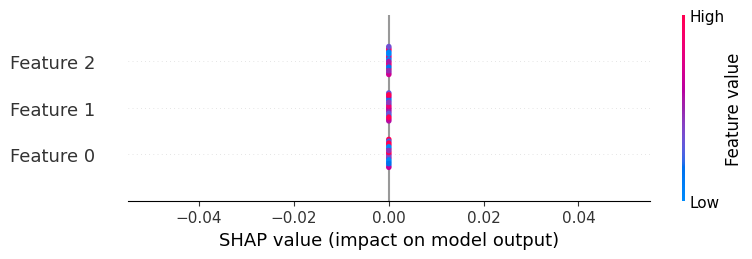

In [47]:
shap.summary_plot(shap_values[:,:,0], x)